# Generate Artificial Faces with CelebA Progressive GAN Model

**Acknowledgements:**
1. [Tutorial](https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module) on Colab.  
2. [Notebook](https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb) on Github.  

**References:**
1. TF resources:
   1. [Low-level concepts](https://www.tensorflow.org/guide/eager)  (TODO: Follow this guide)  
   2. [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack)  
   3. [Progan 128](https://tfhub.dev/google/progan-128/1) pretrained model module on TF-Hub.  
2. GANs:
   1. [GAN article](https://en.wikipedia.org/wiki/Generative_adversarial_network) on Wikipedia.  
   2. Paper on [Noise-contrastive estimation](http://proceedings.mlr.press/v9/gutmann10a/gutmann10a.pdf) which inspired GANs.  
   3. Paper on the [3D-GAN](https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf) which learns a probabilisitic latent space of object shapes from images.  
   4. Paper on [Progressive growing of GANs for improved quality, stability, and variation](https://arxiv.org/abs/1710.10196)  
3. Interpolation:
   1. [Linear Interpolation article](https://en.wikipedia.org/wiki/Linear_interpolation) on Wikipedia.  
   2. Interpolation between [2 vectors](https://gamedev.stackexchange.com/questions/18615/how-do-i-linearly-interpolate-between-two-vectors)  
   3. [Hypersphere article](https://en.wikipedia.org/wiki/Hypersphere) on Wikipedia.  


**Table of contents:**
1. [Overview](#Overview)  
2. [Setup](#Setup)  
3. 

## Overview

A TF-Hub module based on a generative adversarial network (GAN) is used, which maps N-dimentional vectors (the *latent space*) to RGB images.

In particular, two examples are shown:
* **Mapping** from latent space to images  
* Given a target image, **using gradient descent to find a latent vector** that generates an image similar to the target image  

## Setup

In [1]:
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)  # usu. for reproducibility

import tensorflow_hub as hub
from tensorflow_docs.vis import embed

import time

try:
    from google.colab import files
except ImportError:
    pass

from IPython import display
from skimage import transform

/home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# This value could be retrieved from module.get_input_shapes() if 
# the module to be used is not know ahead of time
latent_dim = 512

# Interpolates between two vectors which are non-zero and don't both
# lie on a line through the origin. First, normalizes v2 to have the
# same norm as v1. Then, interpolates between the two vectors on the
# hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)
    
    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
        
        return tf.stack(vectors)
    
    
# Simple way to display an image
def display_image(image):
    image = tf.constant(image)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return PIL.Image.fromarray(image.numpy())


# Given a set of images, show an animation
def animate(images):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)

    return embed.embed_file('./animation.gif')   # TODO: Grok this

logging.set_verbosity(logging.ERROR)

## Latent space interpolation

### Random vectors

Use the TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1), which has a pretrained Progressive GAN, to do latent space interpolation between two randomly initialized vectors.

In [4]:
progan = hub.load('https://tfhub.dev/google/progan-128/1').signatures['default']

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##### Deprecation warning
```
WARNING:tensorflow:From /home/ivogeorg/anaconda3/envs/tf-22/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
```


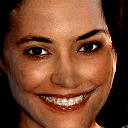

In [5]:
def interpolate_between_vectors():
    v1 = tf.random.normal([latent_dim])  # set at the top of nb
    v2 = tf.random.normal([latent_dim])
    
    # Creates a tensor with 25 steps of interpolation b/n v1 and v2
    vectors = interpolate_hypersphere(v1, v2, 50)  # TODO: Not 50 steps?
    
    # Uses ProGAN module to generate images from the latent space.
    interpolated_images = progan(vectors)['default']
    
    return interpolated_images


interpolated_images = interpolate_between_vectors()
animate(interpolated_images)